# Analysis: PCA of Model Feature Spaces

### **Notebook Objective**

This notebook performs a deep-dive analysis into the internal feature spaces of the QRC and Classical ESN models. The goal is to understand the relationship between a model's performance (MSE) and the "effective dimensionality" of its internal state representation.

### **Process**
1.  **Load Data**: Import the main experiment results from the `.csv` file.
2.  **Iterate Profiles**: Loop through each data profile (e.g., Mackey-Glass, NARMA).
3.  **Analyze Best Classical Model**: For each profile, identify the best Classical ESN, regenerate its internal reservoir states, and calculate its effective dimensionality via PCA.
4.  **Analyze All QRC Models**: For each QRC hyperparameter combination, regenerate its quantum feature space and calculate its effective dimensionality. This is done in parallel for efficiency.
5.  **Visualize**: Create a scatter plot of Performance (MSE) vs. Effective Dimensionality for all QRC models, with the best Classical ESN's dimensionality shown as a reference line.

In [12]:
# === IMPORTS AND SETUP ===
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import our custom modules
from src.data_generation import mackey_glass, generate_arma_data, generate_narma_data, create_io_pairs
from src.models import get_classical_reservoir_states # For classical analysis
from src.analysis import get_qrc_feature_space, calculate_effective_dimension # For QRC analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# Jupyter magic command for automatic reloading of external modules
%load_ext autoreload
%autoreload 2

print("Libraries and modules loaded successfully.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Libraries and modules loaded successfully.


In [13]:
# === CONFIGURATION AND DATA LOADING ===

# Constants needed for regenerating data
TRAIN_FRACTION = 0.7
SEED = 2025
RESULTS_FILENAME = '../data/results_comparative.csv'

# Data profiles config must be available to regenerate the time series
data_profiles_config = [
    {'name': 'Mackey_Glass_(tau=17)', 'generator': mackey_glass, 'params': {'tau': 17}},
    {'name': 'Mackey_Glass_(tau=30)', 'generator': mackey_glass, 'params': {'tau': 30}},
    {'name': 'Mackey_Glass_(tau=100)', 'generator': mackey_glass, 'params': {'tau': 100}},
    {'name': 'ARMA_1_2_stochastic', 'generator': generate_arma_data, 'params': {}},
    {'name': 'NARMA10_Chaotic', 'generator': generate_narma_data, 'params': {'order': 10}},
    {'name': 'NARMA5_Chaotic', 'generator': generate_narma_data, 'params': {'order': 5}}
]

# Load the results
try:
    results_df = pd.read_csv(RESULTS_FILENAME)
    print(f"Successfully loaded results from '{RESULTS_FILENAME}'.")
except FileNotFoundError:
    print(f"ERROR: The file '{RESULTS_FILENAME}' was not found. Please run the experiment notebook first.")
    results_df = pd.DataFrame()

Successfully loaded results from '../data/results_comparative.csv'.



--- Starting PCA analysis for profile: Mackey_Glass_(tau=17) ---

Analyzing the best classical ESN benchmark...
--> Best Classical ESN: Eff. Dim = 3, Median MSE = 4.89e-05


Analyzing QRC models:   0%|          | 0/90 [00:00<?, ?it/s]

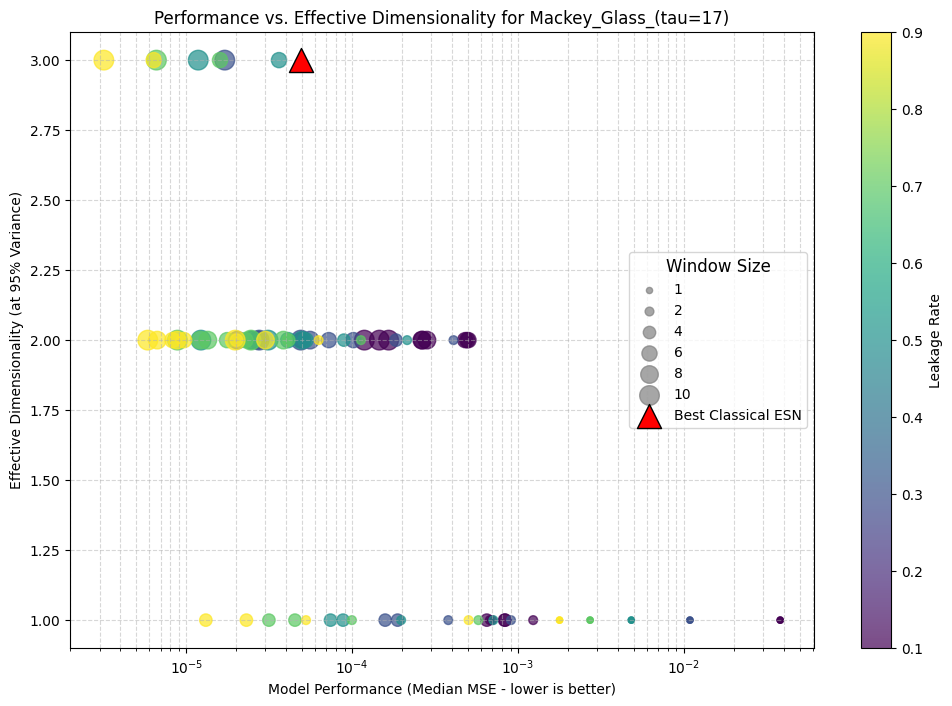


--- Starting PCA analysis for profile: Mackey_Glass_(tau=30) ---

Analyzing the best classical ESN benchmark...
--> Best Classical ESN: Eff. Dim = 4, Median MSE = 9.36e-06


Analyzing QRC models:   0%|          | 0/90 [00:00<?, ?it/s]

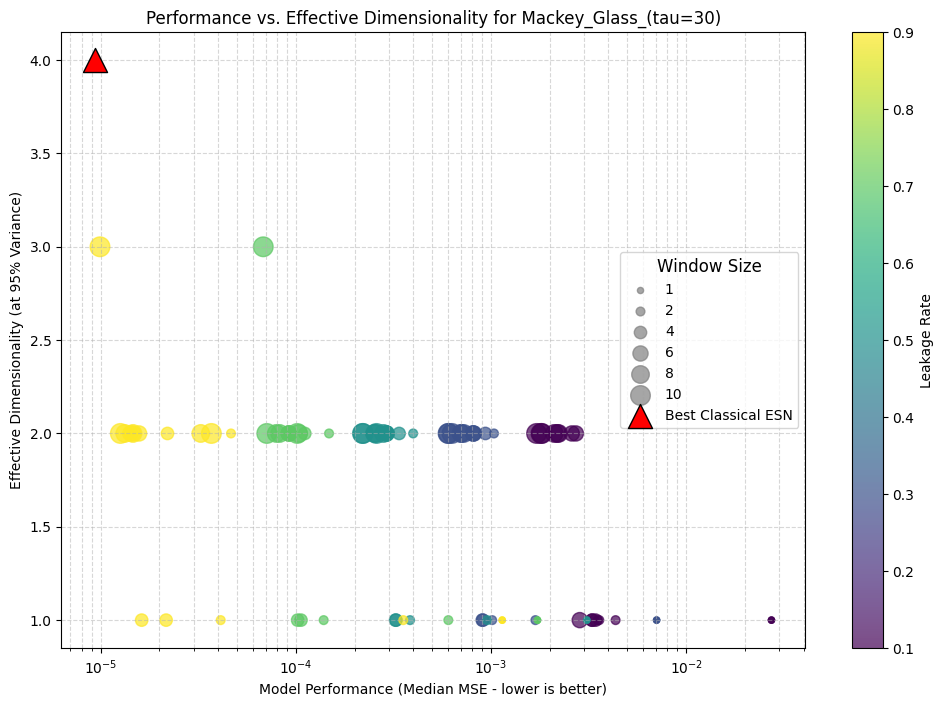


--- Starting PCA analysis for profile: Mackey_Glass_(tau=100) ---

Analyzing the best classical ESN benchmark...
--> Best Classical ESN: Eff. Dim = 1, Median MSE = 1.41e-05


Analyzing QRC models:   0%|          | 0/90 [00:00<?, ?it/s]

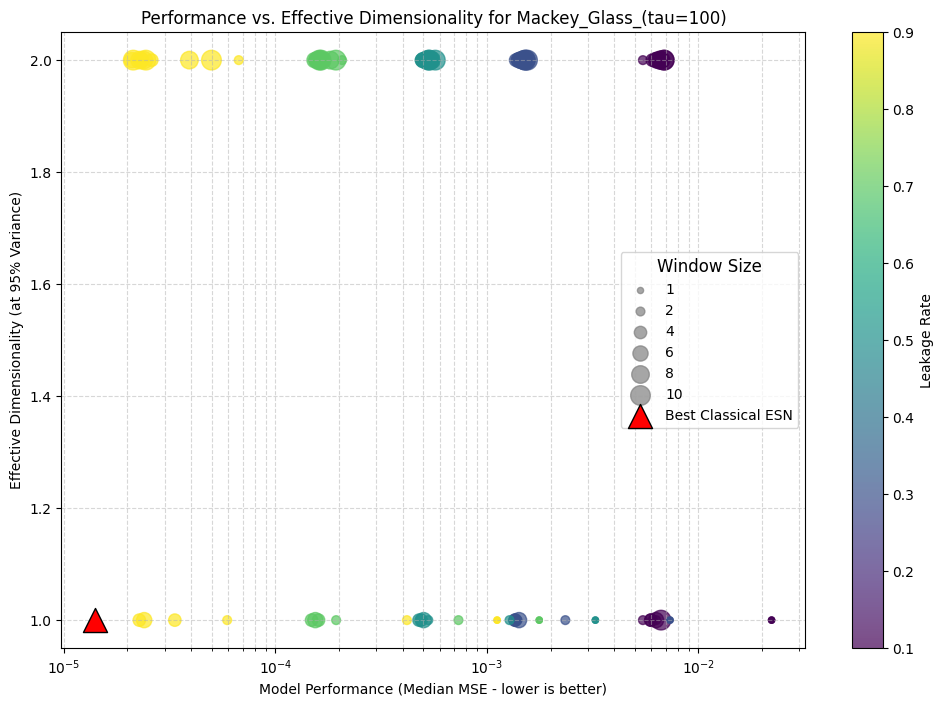


--- Starting PCA analysis for profile: ARMA_1_2_stochastic ---

Analyzing the best classical ESN benchmark...
--> Best Classical ESN: Eff. Dim = 9, Median MSE = 8.00e-03


Analyzing QRC models:   0%|          | 0/90 [00:00<?, ?it/s]

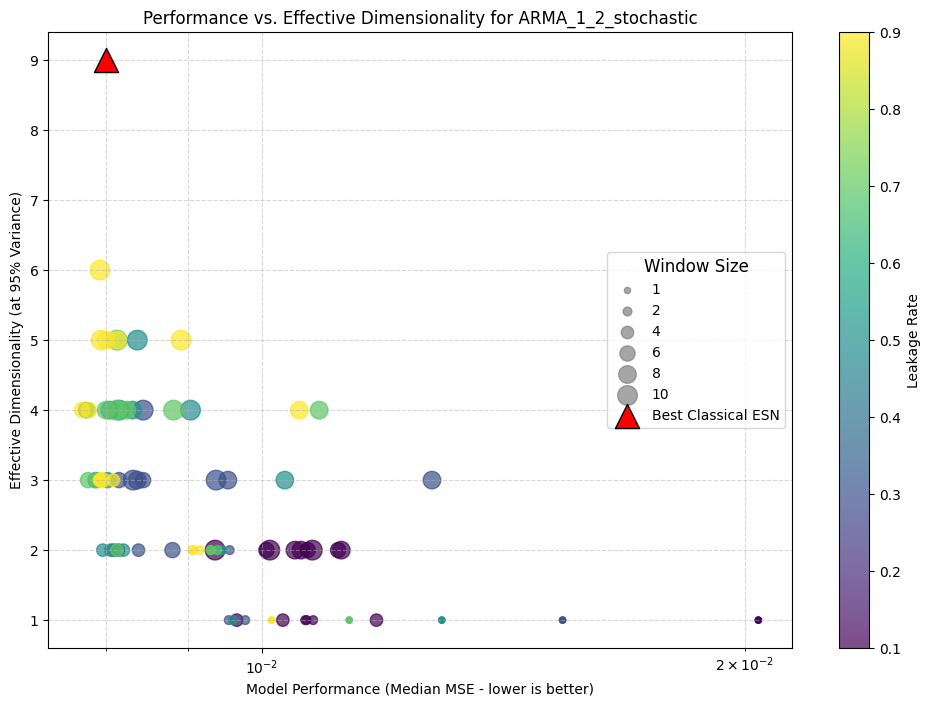


--- Starting PCA analysis for profile: NARMA10_Chaotic ---

Analyzing the best classical ESN benchmark...
--> Best Classical ESN: Eff. Dim = 10, Median MSE = 7.72e-03


Analyzing QRC models:   0%|          | 0/90 [00:00<?, ?it/s]

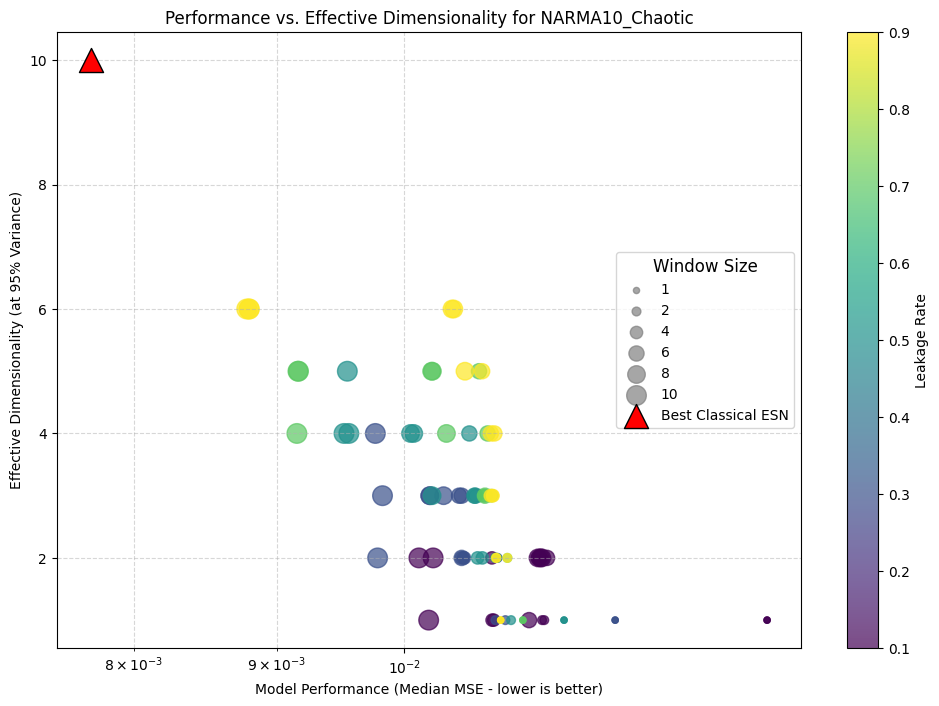


--- Starting PCA analysis for profile: NARMA5_Chaotic ---

Analyzing the best classical ESN benchmark...
--> Best Classical ESN: Eff. Dim = 11, Median MSE = 1.21e-02


Analyzing QRC models:   0%|          | 0/90 [00:00<?, ?it/s]

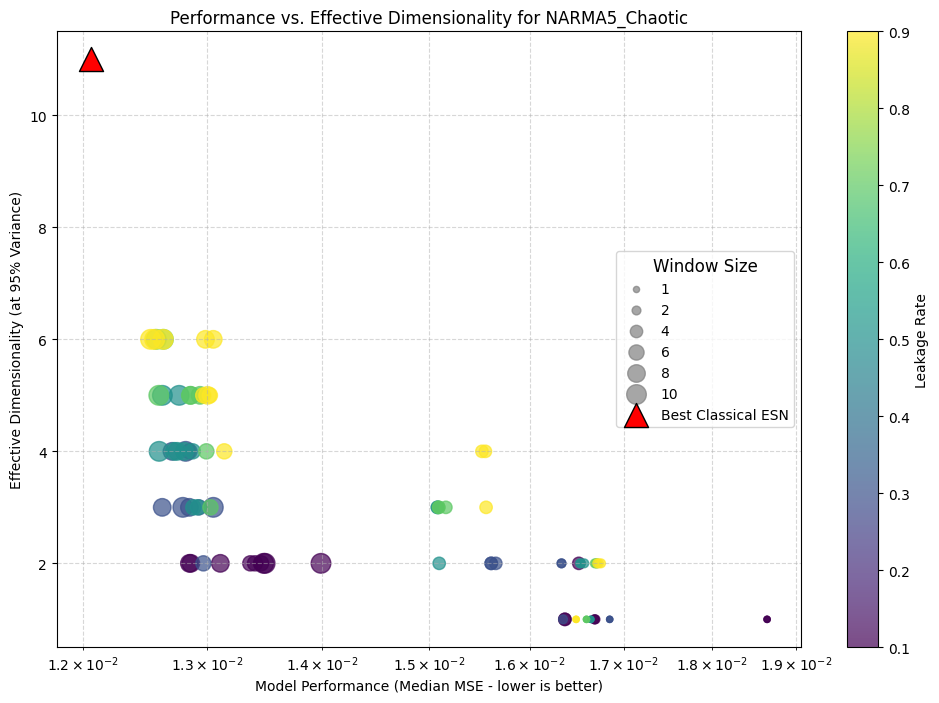

In [14]:
# === PCA ANALYSIS AND PLOTTING LOOP ===

# Helper function to be parallelized for QRC analysis
def calculate_eff_dim_for_qrc_row(row, time_series, train_fraction, seed):
    """Wrapper function for joblib parallelization."""
    params_tuple = (
        row['leakage_rate'], row['lambda_reg'],
        int(row['window_size']), int(row['n_layers']), int(row['lag'])
    )
    features = get_qrc_feature_space(params_tuple, time_series, train_fraction, seed)
    return calculate_effective_dimension(features)

if not results_df.empty:
    for profile_config in data_profiles_config:
        profile_name = profile_config['name']
        print(f"\n{'='*80}\n--- Starting PCA analysis for profile: {profile_name} ---\n")

        profile_df = results_df[results_df['data_profile'] == profile_name]
        qrc_df = profile_df[profile_df['model_type'] == 'QRC'].copy().dropna(subset=['median_mse'])
        classical_df = profile_df[profile_df['model_type'] == 'Classical_ESN'].copy().dropna(subset=['median_mse'])

        if qrc_df.empty or classical_df.empty:
            print(f"--> WARNING: Skipping profile '{profile_name}' due to missing data.")
            continue

        time_series = profile_config['generator'](**profile_config['params'])
        
        # --- 1. Analyze the BEST Classical ESN ---
        print("Analyzing the best classical ESN benchmark...")
        best_classical_row = classical_df.loc[classical_df['median_mse'].idxmin()]
        classical_win_size = int(best_classical_row.get('window_size', 10))
        train_inputs_classical, _ = create_io_pairs(time_series[:int(len(time_series) * TRAIN_FRACTION)], classical_win_size)
        
        classical_states = get_classical_reservoir_states(
            train_inputs=train_inputs_classical,
            reservoir_size=int(best_classical_row['reservoir_size']),
            leakage_rate=best_classical_row['leakage_rate'],
            spectral_radius=best_classical_row['spectral_radius'],
            sparsity=best_classical_row['sparsity'],
            seed=SEED,
            input_dim=classical_win_size
        )
        eff_dim_classical = calculate_effective_dimension(classical_states)
        mse_classical = best_classical_row['median_mse']
        print(f"--> Best Classical ESN: Eff. Dim = {eff_dim_classical}, Median MSE = {mse_classical:.2e}")

        # --- 2. Parallel PCA Analysis for ALL QRC models ---
        effective_dims = Parallel(n_jobs=-1)(
            delayed(calculate_eff_dim_for_qrc_row)(row, time_series, TRAIN_FRACTION, SEED)
            for _, row in tqdm(qrc_df.iterrows(), total=qrc_df.shape[0], desc=f"Analyzing QRC models")
        )
        qrc_df['effective_dim'] = effective_dims

        # --- 3. Create the Scatter Plot ---
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(
            qrc_df['median_mse'], qrc_df['effective_dim'], c=qrc_df['leakage_rate'], 
            cmap='viridis', alpha=0.7, s=qrc_df['window_size']*20
        )
        
        # Plot the Best Classical ESN as a distinct triangle
        plt.scatter(
            mse_classical,
            eff_dim_classical,
            marker='^',          # Triangle marker
            s=300,               # Large size
            c='red',             # Contrasting color
            edgecolors='black',  # Black edge for visibility
            label='Best Classical ESN', # SIMPLIFIED LABEL
            zorder=10            # Ensure it's drawn on top of other points
        )

        cbar = plt.colorbar(scatter, label='Leakage Rate')
        plt.title(f'Performance vs. Effective Dimensionality for {profile_name}')
        plt.xlabel('Model Performance (Median MSE - lower is better)')
        plt.ylabel('Effective Dimensionality (at 95% Variance)')
        plt.xscale('log')
        plt.grid(True, which="both", ls="--", alpha=0.5)
        
        # --- CHANGES FOR THE LEGEND ---
        
        # Create handles for Window Size circles
        size_handles = [plt.scatter([], [], s=size*20, label=f'{int(size)}', c='gray', alpha=0.7) for size in sorted(qrc_df['window_size'].unique())]
        
        # Create a handle for the Best Classical ESN triangle
        classical_handle = plt.scatter([], [], s=300, marker='^', c='red', edgecolors='black', label='Best Classical ESN')
        
        # Combine all handles and labels
        all_handles = size_handles + [classical_handle]
        
        # Create the combined legend with a title
        plt.legend(handles=all_handles, title='Window Size', loc='center right', fontsize=10, title_fontsize=12)
        
        plt.savefig(f"../reports/figures/{profile_name}_pca_analysis.png", dpi=300)
        plt.show()